# Convex Optimization - Homework 3

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Interior Points Method

- Implement the functions phi(x,t,Q,p,A,b), grad(x,t,Q,p,A,b)and hess(x,t,Q,p,A,b) which return respectively the function value, gradient and hessian of φt(x) at point x.

In [10]:
import numpy as np                                                                                 
import pandas as pd                                                                                
import sklearn as sk                                                                               
from sklearn.model_selection import train_test_split                                               
import matplotlib.pyplot as plt                                                                    
                                                                                                   
def log_barrier(x):                                                                                
                                                                                                   
    x_log = np.log(x)                                                                              
                                                                                                   
    return(np.sum(x_log))                                                                          
                                                                                                   
def grad_log_barrier(A, b, x):                                                                     
                                                                                                                                                      
    result = np.zeros(A.shape[1])                                                                  
                                                                                                                                                         
    for i in range(A.shape[0]):                                                                    
                                                                                                   
        coeff = 1 / (b[i] - np.dot(A[i,:], x))                                                     
        result += coeff * A[i,:]                                                                   
                                                                                                   
    return(result)                                                                                 
                                                                                                   
def hess_log_barrier(A, b, x):                                                                     
                                                                                                   
    result = np.zeros([A.shape[1], A.shape[1]])                                                    
                                                                                                   
    for i in range(A.shape[0]):                                                                    
                   
        coeff = 1 / ((b[i] - np.dot(A[i,:], x)) ** 2)                                              
                                                                                                   
        result += coeff * np.outer(A[i,:], A[i,:])                                                 
                                                                                                   
    return(result) 

def phi(x, t, Q, p, A, b):                                    
                                                              
    quadratic = (1 / 2) * np.dot(x, np.dot(Q,x)) + np.dot(p,x)
    barrier = log_barrier(b - np.dot(A, x))                   
                                                              
    return(t * quadratic + barrier)                           
                                                              
def grad(x, t, Q, p, A, b):                                   
                                                              
    #print(Q,x, p)                                            
                                                              
    quadratic = np.dot(Q,x) + p                               
    barrier = grad_log_barrier(A, b, x)                       
                                                              
    return(t * quadratic + barrier)                           
                                                              
def hess(x, t, Q, p, A, b):                                   
                                                              
    quadratic = Q                                             
    barrier = hess_log_barrier(A, b, x)                       
                                                              
    return( t * quadratic + barrier)                          

## 2. Newton Method

- Implement the function [xnew,gap] = dampedNewtonStep(x,f,g,h), which compute the damped Newton step at point x. Assume the argument f is a function which takes input x and returns φt(x) (the same for g and h for the gradient and the hessian). The output gap is the estimated gap between φt(xnew) and minx φt(x) (see lecture notes). Note: this function should call one and only one time g(x) and h(x).

- Implement the function [xstar,xhist] = dampedNewton(x0,f,g,h,tol) which min- imizes the function f starting at x0 using the damped Newton algorithm. The output xstar is the estimated minimum, which satisfies φt(xstar) − minx φt(x) ≤ tol. The output xhist contains the history of all Newton steps.

- Implement a function [xstar,xhist] = newtonLS(x0,f,g,h,tol) which minimizes the function f starting at x0 using the Newton algorithm with backtracking line-search (see lecture notes).

In [42]:
def dampedNewtonStep(x,f,g,h):                                         
                                                                       
    grad = g(x)                                                        
    hess = h(x)                                                        
    hess = hess + 0.01 * np.identity(hess.shape[0])                    
    hess = np.array(hess, dtype = float)                               
    #print(hess)                                                       
    hess_inv = np.linalg.inv(hess)                                     
                                                                       
    decrement = np.dot(grad, np.dot(hess_inv,grad))                    
                                                                       
    xnew = x - ( 1/ (1 + np.sqrt(decrement))) * np.dot(hess_inv, grad) 
                                                                       
    gap = decrement / 2                                                
                                                                       
    return(xnew, gap)                                                  
                                                                       
def dampedNewton(x0,f,g,h,tol):                                        
                                                                       
    x = x0                                                             
    xhist = np.array(x0)                                               
                                                                       
    gap = 1                                                            
                                                                       
    while gap > tol:                                                   
        xnew, gap = dampedNewtonStep(x,f,g,h)                          
        x = xnew                                                       
        xhist = np.append(xhist, x)                                    
    xstar = x                                                          
                                                                       
    return(xstar, xhist)                                               
                                                                       
def check_feasible_p(w,z,tau,X,Y):                                     
                                                                       
    if (z<0).any():                                                  
          return(False)                                                                                                                 
    elif ((Y*(w.T.dot(X))<(np.ones(z.shape(0)) - z)).any()):           
          return(False)                                                
                                                                       
    return(True)                                                     
                                                                       
def check_feasible_d(lmbda,tau,X,Y):
    
    return ((lmbda>=0).all() and (lmbda<=1/(tau*X.shape[1])).all())
    
def newtonLS(x0,f,g,h,tol,solver,tau,X,y):                                                 
                                                                            
    x = x0                                                                  
    xhist = np.array(x0)                                                    
                                                                            
    gap = 1                                                                 
                                                                            
    alpha = 0.2                                                             
    beta = 0.5                                                              
                                                                            
    while gap > tol:                                                        
                                                                            
        grad = g(x)
        hess = h(x) + 0.01 * np.identity(h(x).shape[0])
        hess_inv = np.linalg.inv(hess)                                      
        nstep = np.dot(hess_inv, grad)                                      
        gap = np.dot(grad, nstep) / 2                                       
                                                                            
        ### line-search                                                     
        t = 1                                                               
        criterion = f(x - t * nstep) - f(x) + alpha * t * 2 * gap > 0       
        if solver == 'primal':                                                                   
            while criterion == True or check_feasible_p(x - t * nstep,tau,X,y) == False:
                t = beta * t
        elif solver == 'dual':
            while criterion == True or check_feasible_d(x - t * nstep, tau,X,y) == False:
                t = beta * t
                                                                            
        x = x - t * nstep                                                   
        xhist = np.append(xhist, x)                                         
                                                                            
    xstar = x                                                               
                                                                            
    return(xstar, xhist)                                                    

## 3. Support Vector Machine Problem

Implement the barrier method(using logarithmic barrier) to solve (SVM-P) and (SVM-D) given a data matrix X = (xT1 ,...,xTn) ∈ Rn×d, a vector of labels y ∈ {−1,1}n and a regularization parameter τ > 0 by :

- Coding the generic functions [Q,p,A,b] = transform svm primal(tau,X,y) and [Q,p,A,b] = transform svm dual(tau,X,y), which writes the primal and the dual SVM problem as particular instances of the quadratic problem (QP).
- Coding a function [x sol,xhist] = barr method(Q,p,A,b,x 0,mu,tol) which implements the barrier method to solve QP given the inputs (Q, p, A, b) and the initial point x 0 (which should be strictly feasible). The input mu is the increment of the barrier at each iteration (see lecture notes). The output x sol must be feasible and satisfies φ(x sol) − φ(x∗) ≤ tol where x∗ is the solution of (QP). The function also outputs xhist, the history of all Newton steps.

In [35]:
def transform_svm_primal(tau,X,y):                                   
                                                                     
    n = X.shape[0]                                                   
    d = X.shape[1]                                                   
                                                                     
    p = np.zeros(X.shape[1] + X.shape[0])                            
    for i in range(X.shape[1], X.shape[1] + X.shape[0] ):            
        p[i] = 1 / (tau * n)                                         
                                                                     
    Q = np.zeros([n+d, n+d])                                         
    for i in range(d):                                               
        Q[i,i] = 1                                                   
    #print(Q)                                                        
                                                                     
    b = np.zeros(2 * X.shape[0])                                     
    for i in range(X.shape[0], 2 * X.shape[0]):                      
        b[i] = - 1                                                   
                                                                     
    # Define A, à vérifier                                           
    A = np.zeros((2 * n, n + d))                                     
                                                                     
    for i in range(n):                                               
        for j in range(d):                                           
            A[i, j] = y[i] * X[i, j]                                 
        for j in range(n):                                           
            A[i, j + d] = -1                                         
    for i in range(n):                                               
        A[n + i, d + i] = -1                                         
                                                                     
    return(Q, p , A, b)                                              
                                                                     
def transform_svm_dual(tau,X,y):                                     
                                                                     
    Y = np.diag(y)                                                   
    XY = np.dot(X.T, Y)                                              
    Q = np.dot(XY.T,XY)                                              
                                                                     
                                                                     
                                                                     
    p = - np.ones(X.shape[0])                                        
                                                                     
    A_1 = - np.eye(X.shape[0])                                       
    A_2 = np.eye(X.shape[0])                                         
    A = np.concatenate((A_1, A_2), axis=0)                           
                                                                     
    b = np.zeros(2 * X.shape[0])                                     
    for i in range(X.shape[0], 2 * X.shape[0]):                      
        b[i] = 1 / (tau * X.shape[0])                                
                                                                     
    return(Q, p , A, b)

def barr_method(Q,p,A,b,x_0,mu,tol):                                                                
                                                                                                    
    t = 1                                                                                           
    criterion = 10000                                                                               
    xhist = [x_0]                                                                                   
    x = x_0                                                                                         
                                                                                                    
    while criterion > tol:                                                                          
                                                                                                    
        # centering step                                                                            
                                                                                                    
        # Declare f as an anonymous function which takes one # input x, and returns phi(x,t,Q,p,A,b)
        f = lambda x: phi(x, t, Q, p, A, b);                                                        
        g = lambda x: grad(x, t, Q, p, A, b);  # same                                               
        h = lambda x: hess(x, t, Q, p, A, b);  # same                                               
                                                                                                    
        x, xhist_d = dampedNewton(x,f,g,h,tol)                                                      
                                                                                                    
        # update                                                                                                                                                                              
        xhist = np.append(xhist,[x], axis = 0)                                                      
                                                                                                    
        # stopping criterion                                                                        
        criterion = b.shape[0] / t                                                                  
                                                                                                    
        # increase t                                                                                
        t = t * mu                                                                                  
                                                                                                    
    x_sol = x                                                                                       
                                                                                                    
    return(x_sol, xhist)                                                                            

- Use the Iris dataset (https://archive.ics.uci.edu/ml/datasets/iris) to test your code and try to separate the last two classes, i.e., Iris-versicolor versus Iris-virginica. Try different values of τ and measure out-of-sample performance by learning the classifier on 80% of the dataset. Add one dimension to your data points in order to account for the offset if your data is not centered

In [36]:
### YOU'RE GOING TO NEED TO USE YOUR OWN PATH TO THE IRIS DATASET HERE.
input_file = '/Users/gregoire/Desktop/mva/tutorials/iris-species/iris.csv'             
                                                                                       
dataset = pd.read_csv(input_file)                                                      
dataset = dataset.drop('Id', axis = 1)                                                 
dataset = dataset.drop(dataset[dataset.Species == 'Iris-setosa'].index)                
                                                                                       
                                                                                       
dataset['Label'] = pd.DataFrame(np.zeros(dataset.shape[0]))                            
                                                                                       
dataset_array = np.array(dataset)                                                      
                                                                                       
for i in range(dataset_array.shape[0]):                                                
    if dataset_array[i,4] == 'Iris-virginica':                                         
        dataset_array[i,5] = 1                                                         
    elif dataset_array[i,4] == 'Iris-versicolor':                                      
        dataset_array[i,5] = -1                                                        
                                                                                       
dataset = pd.DataFrame(dataset_array)                                                  
dataset = dataset.drop(4, axis = 1)                                                    
# data is standardized                                                                 
dataset = (dataset - dataset.mean()) / dataset.std()                                   
dataset['ord'] = pd.DataFrame(np.ones(dataset.shape[0]))                               
                                                                                       
                                                                                       
data = np.array(dataset)                                                               
                                                                                       
X, X_test, y, y_test = train_test_split(data[:,[0,1,2,3,5]], data[:,4], test_size= 0.2)

Here we implement primal and dual solvers as well as classifiers.

In [37]:
def primal_solver(tau, mu):                                           
                                                                      
    Q, p, A, b = transform_svm_primal(tau, X, y)                      
    # generating feasible point                                       
    x_0 = np.zeros(X.shape[0] + X.shape[1])                           
    for i in range(X.shape[0]):                                       
        x_0[i] = 2                                                    
                                                                      
    x_sol, xhist = barr_method(Q, p, A, b, x_0, mu, 0.1 )             
                                                                      
    return (x_sol, xhist)                                             
                                                                      
#x_sol, xhist = primal_solver(1)                                      
                                                                      
def dual_solver(tau, mu):                                             
                                                                      
    Q, p, A, b = transform_svm_dual(tau, X, y)                        
    n = X.shape[0]                                                    
    # generating feasible point                                       
    x_0 = np.zeros(n)                                                 
    for i in range(n):                                                
        x_0[i] = 1 / (2 * tau * n)                                    
                                                                      
    x_sol, xhist = barr_method(Q, p, A, b, x_0, mu, 0.1)              
                                                                      
    return (x_sol, xhist)                                             
                                                                      
# here we test the solutions we get on our iris-dataset               
                                                                      
def predict_primal(X, y, tau, mu):                                    
                                                                      
    n = X.shape[0]                                                    
    d = X.shape[1]                                                    
    pred = np.zeros(n)                                                
    x, xhist = primal_solver(tau, mu)                                 
    w = np.zeros(d)                                                   
    z = np.zeros(n)                                                   
    for i in range(d):                                                
        w[i] = x[i]                                                   
    for i in range(n):                                                
        z[i] = x[i + d]                                               
    for i in range(n):                                                
        if np.sign(np.dot(X[i,:],w)) != - np.sign(y[i]):              
            pred[i] = 1                                               
    classif_error = np.sum(pred)                                      
                                                                      
    return(classif_error)                                             
                                                                      
print('Prediction with primal :', predict_primal(X_test, y_test, 1, 20))

def predict_dual(X,y,tau, mu):                                                         
                                                                                       
    n = X.shape[0]                                                                     
    d = X.shape[1]                                                                     
    pred = np.zeros(n)                                                                 
                                                                                       
    w = np.zeros(d)                                                                    
                                                                                       
    l, lhist = dual_solver(tau, mu)                                                    
                                                                                       
    for i in range(n):                                                                 
        w = w + l[i] * y[i] * X[i,:]                                                   
    for i in range(n):                                                                 
        if np.sign(np.dot(X[i,:],w)) != np.sign(y[i]):                                 
            pred[i] = 1                                                                
    classif_error = np.sum(pred)                                                       
                                                                                       
    return(classif_error)                                                              
                                                                                       
print('Prediction with dual:', predict_dual(X_test, y_test, 1, 20))                       
                                                                                       
for tau in (0.1,1,10,100,1000,10000):                                                     
    print('Tau :', tau)                                                               
    print('Classification error for the primal :', predict_primal(X_test,y_test,tau, 20)) 
    print('Classification error for the dual :', predict_dual(X_test, y_test, tau, 20))   
                                                                                       
# TO DO : Test line-search                                                             

Prediction with primal : 1.0
Prediction with dual: 2.0
Tau : 0.1
Classification error for the primal : 0.0
Classification error for the dual : 3.0
Tau : 1
Classification error for the primal : 1.0
Classification error for the dual : 2.0
Tau : 10
Classification error for the primal : 1.0
Classification error for the dual : 1.0
Tau : 100
Classification error for the primal : 1.0
Classification error for the dual : 1.0
Tau : 1000
Classification error for the primal : 1.0
Classification error for the dual : 1.0
Tau : 10000
Classification error for the primal : 1.0
Classification error for the dual : 1.0


Both dual and primal solution do well on the iris dataset. The regularization (the bigger tau, the more we regularize) does not really change the result. The error is slightly slower with less regularization which could also mean over-fitting.

- Plot the duality gap versus iterations (using the damped Newton Method) for the primal and dual problem in semilog-scale for different values of the barrier method parameter μ = 2, 15, 50, 100 and comment the results. Compare the performance with the line-search strategy. Hint: Use the fact that any primal solution is an upper bound for the dual problem and vice-versa.

Here we tried to solve our primal and dual problem via Newton Line Search (The check_feasible methods were missing, we did not implement it by lack of time).

In [43]:
### DOES NOT WORK
def barr_method_LS(Q,p,A,b,x_0,mu,tol,solver,tau, X, y):                                                                
                                                                                                    
    t = 1                                                                                           
    criterion = 10000                                                                               
    xhist = [x_0]                                                                                   
    x = x_0                                                                                         
                                                                                                    
    while criterion > tol:                                                                          
                                                                                                    
        # centering step                                                                            
                                                                                                    
        # Declare f as an anonymous function which takes one # input x, and returns phi(x,t,Q,p,A,b)
        f = lambda x: phi(x, t, Q, p, A, b);                                                        
        g = lambda x: grad(x, t, Q, p, A, b);  # same                                               
        h = lambda x: hess(x, t, Q, p, A, b);  # same                                               
                                                                                                    
        x, xhist_d = newtonLS(x,f,g,h,tol,solver,tau,X,y)                                                      
                                                                                                    
        # update                                                                                                                                                                              
        xhist = np.append(xhist,[x], axis = 0)                                                      
                                                                                                    
        # stopping criterion                                                                        
        criterion = b.shape[0] / t                                                                  
                                                                                                    
        # increase t                                                                                
        t = t * mu                                                                                  
                                                                                                    
    x_sol = x                                                                                       
                                                                                                    
    return(x_sol, xhist)

def primal_solver_LS(tau, mu):                                           
                                                                      
    Q, p, A, b = transform_svm_primal(tau, X, y)                      
    # generating feasible point                                       
    x_0 = np.zeros(X.shape[0] + X.shape[1])                           
    for i in range(X.shape[0]):                                       
        x_0[i] = 2                                                    
                                                                      
    x_sol, xhist = barr_method_LS(Q, p, A, b, x_0, mu, 0.1, 'primal',tau, X, y)             
                                                                      
    return (x_sol, xhist)                                             
                                                                      
x_sol, xhist = primal_solver_LS(1, 20)

/Users/gregoire/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


TypeError: check_feasible_p() missing 1 required positional argument: 'Y'

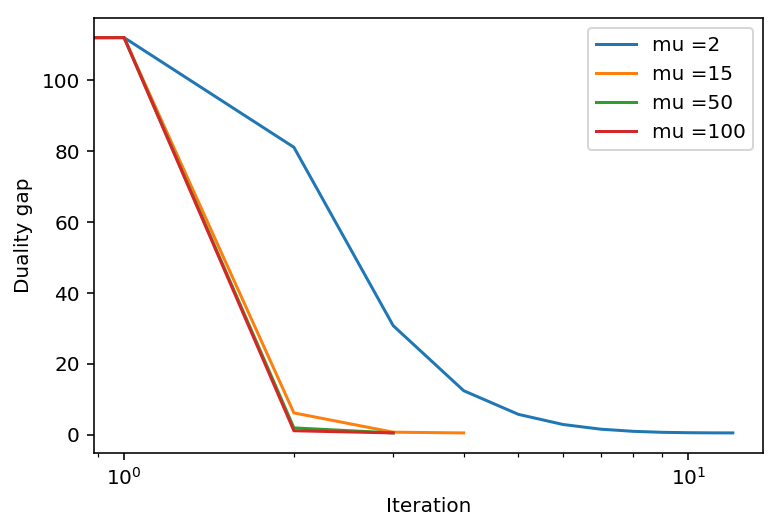

()

In [21]:
def phi_nob(x, Q, p):                                         
                                                              
    quadratic = (1 / 2) * np.dot(x, np.dot(Q,x)) + np.dot(p,x)
                                                              
    return(quadratic)                                         
                                                              
def plot_d_gap(tau):                                          
                                                              
    mu = (2, 15, 50, 100)                                     
                                                              
    for m in mu:                                              
                                                              
        p, phist = primal_solver(tau, m)                      
        d, dhist = dual_solver(tau,m)                         
                                                              
        #print(phist, dhist)                                  
        Q_p, p_p, A_p, b_p = transform_svm_primal(tau,X,y)    
        f_p = lambda x: phi_nob(x, Q_p, p_p);                 
        Q_d, p_d, A_d, b_d = transform_svm_dual(tau,X,y)      
        f_d = lambda x: phi_nob(x, Q_d, p_d);                 
                                                              
        seq = np.zeros(min(len(phist),len(dhist)))            
                                                              
        for i in range(min(len(phist),len(dhist))):           
                                                              
            seq[i] = f_p(phist[i]) - f_d(dhist[i])            
                                                              
        plt.plot(seq, '-', label = "mu ={0}".format(m))       
        plt.legend()
        
                                                        
    
    plt.xscale('log')                                         
    plt.ylabel('Duality gap')                                 
    plt.xlabel('Iteration')
    plt.show()                                                
                                                              
    return()                                                  
                                                              
plot_d_gap(1)                                                 

The bigger mu, the less iterations it takes. Yet, one should keep in mind that a bigger mu implies more inner iterations, i.e Newton iterations.